Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 151MB/s]


Image 0, Prediction 0, IoUs: [0.0, 0.0]
Image 0, Prediction 1, IoUs: [0.0, 0.0]
Image 0, Prediction 2, IoUs: [0.0, 0.0]
Image 1, Prediction 0, IoUs: [0.0, 0.22756375606636473, 0.18918688398099281]
Image 1, Prediction 1, IoUs: [0.0, 0.0, 0.0]
Image 1, Prediction 2, IoUs: [0.0, 0.0, 0.0]
Image 1, Prediction 3, IoUs: [0.0, 0.0, 0.0]
Image 1, Prediction 4, IoUs: [0.0, 0.4297333643077461, 0.0]
Image 1, Prediction 5, IoUs: [0.0, 0.0, 0.0]
Image 1, Prediction 6, IoUs: [0.0, 0.01336214875055689, 0.21255134656125074]
Image 2, Prediction 0, IoUs: [0.018118622091982516]
Image 3, Prediction 0, IoUs: [0.0, 0.0, 0.0]
Image 3, Prediction 1, IoUs: [0.0, 0.0, 0.0]
Image 3, Prediction 2, IoUs: [0.0, 0.0, 0.0]
Image 3, Prediction 3, IoUs: [0.0, 0.0, 0.0]
mAP: 0.0833


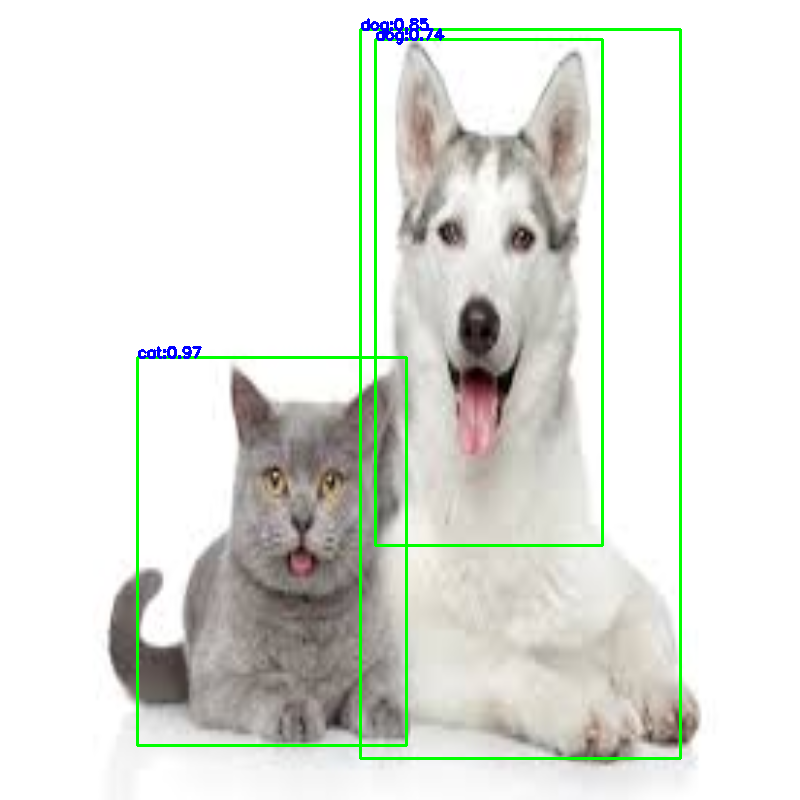

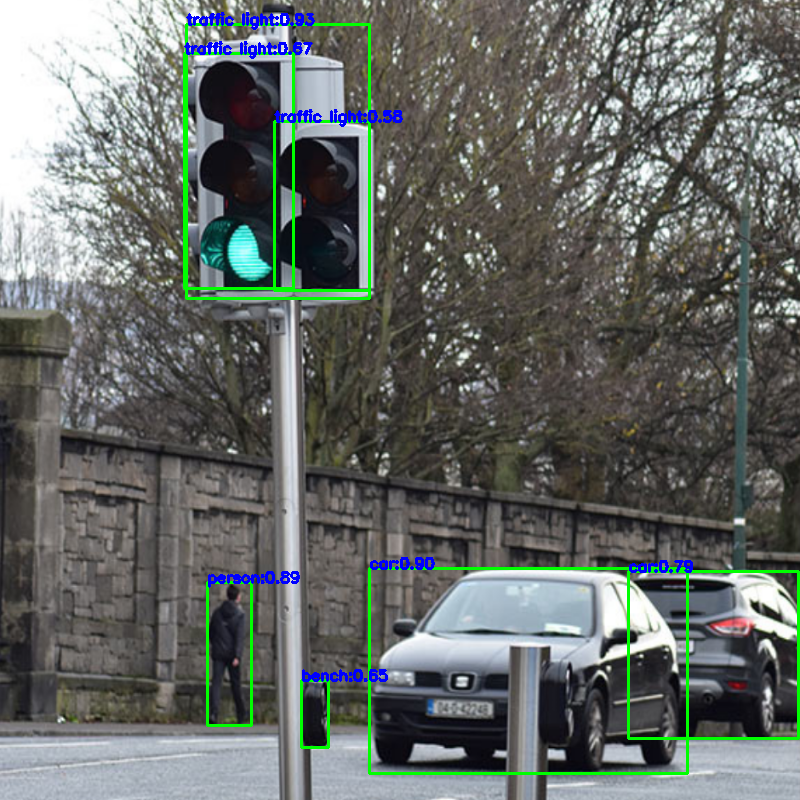

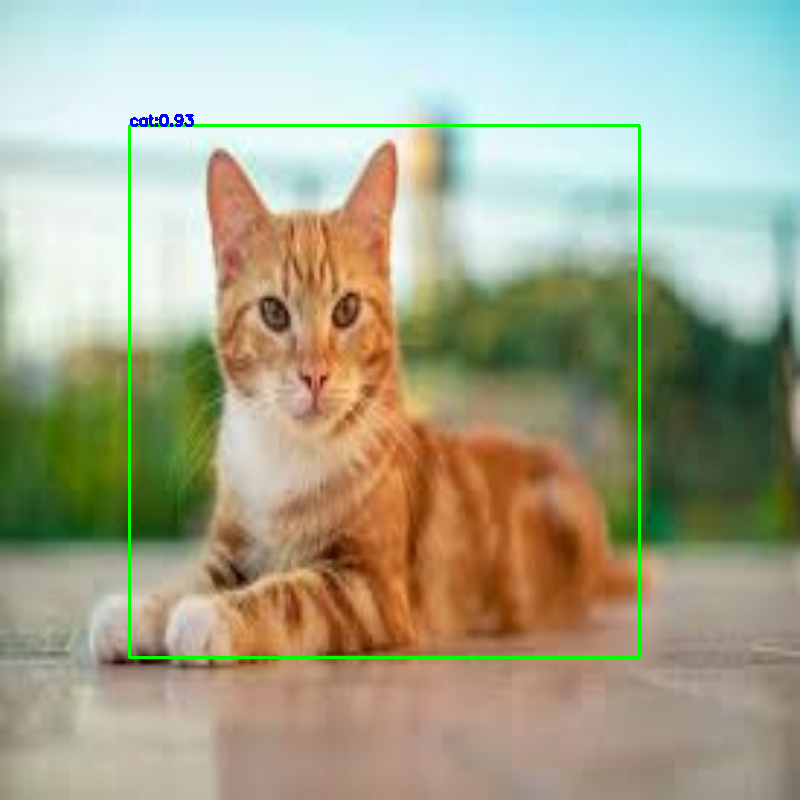

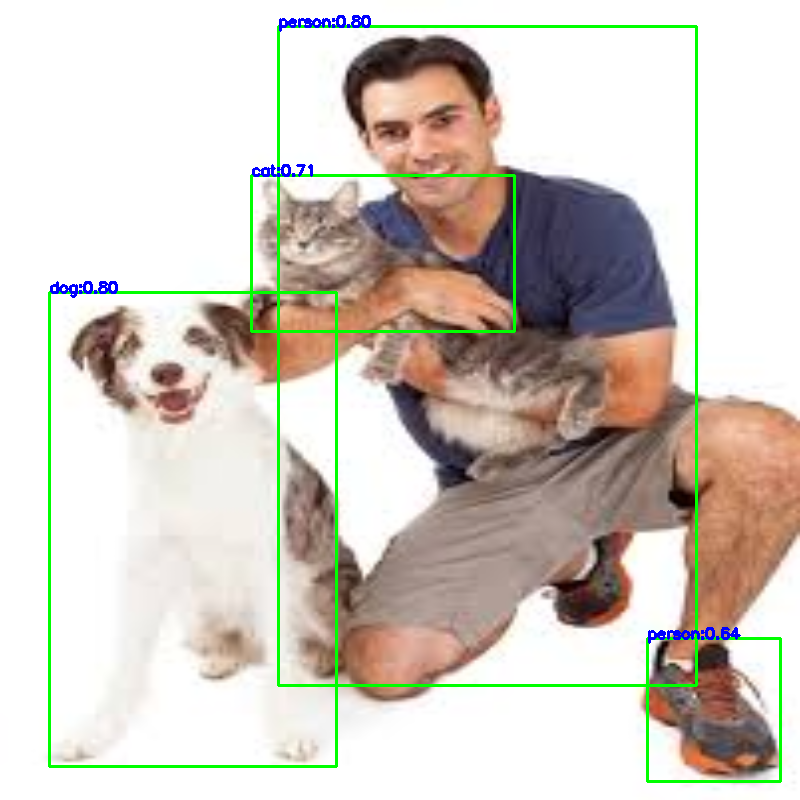

In [1]:
import os
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.metrics import average_precision_score
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights

# Load the pre-trained RetinaNet model with updated weights
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.retinanet_resnet50_fpn(weights=weights)
model.eval()

# COCO dataset class labels
COCO_LABELS = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'none', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Resize function
def resize_image(image, target_size=(800, 800)):
    return cv2.resize(image, target_size)

# IoU calculation
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2
    inter_x1 = max(x1, x1_gt)
    inter_y1 = max(y1, y1_gt)
    inter_x2 = min(x2, x2_gt)
    inter_y2 = min(y2, y2_gt)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

# Batch detection function
def detect_objects_batch(image_folder, ground_truths, confidence_threshold=0.5, iou_threshold=0.3):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_paths:
        print(f"No images found in folder: {image_folder}")
        return [], []

    images = [cv2.imread(image_path) for image_path in image_paths if cv2.imread(image_path) is not None]
    if not images:
        print("No valid images to process.")
        return [], []

    resized_images = [resize_image(image) for image in images]
    image_tensors = [F.to_tensor(image) for image in resized_images]
    batch = torch.stack(image_tensors)

    with torch.no_grad():
        predictions = model(batch)

    true_positive = []
    pred_scores = []
    pred_labels = []
    output_images = []

    for i, original_image in enumerate(resized_images):
        prediction = predictions[i]
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        if i not in ground_truths:
            print(f"No ground truth available for image {i}, skipping...")
            continue

        gt_boxes = ground_truths[i]['boxes']
        gt_labels = ground_truths[i]['labels']

        for j, box in enumerate(boxes):
            if scores[j] >= confidence_threshold:
                pred_scores.append(scores[j])
                pred_labels.append(labels[j])
                iou_values = [calculate_iou(box, gt_box) for gt_box in gt_boxes]

                # Print the IoU values
                print(f"Image {i}, Prediction {j}, IoUs: {iou_values}")

                max_iou = max(iou_values) if iou_values else 0
                if max_iou >= iou_threshold:
                    true_positive.append(1)
                else:
                    true_positive.append(0)

                label = COCO_LABELS[labels[j]]
                start_point = (int(box[0]), int(box[1]))
                end_point = (int(box[2]), int(box[3]))
                cv2.rectangle(original_image, start_point, end_point, (0, 255, 0), 2)
                cv2.putText(original_image, f"{label}:{scores[j]:.2f}", start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        output_images.append(original_image)

    if pred_scores and true_positive:
        mAP = average_precision_score(true_positive, pred_scores)
    else:
        print("No valid predictions for mAP calculation.")
        mAP = 0

    print(f"mAP: {mAP:.4f}")
    return output_images, mAP

# Ground truth data
ground_truths = {
    0: {'boxes': np.array([[50, 50, 200, 200], [180, 50, 300, 200]]), 'labels': np.array([17, 18])},
    1: {'boxes': np.array([[30, 40, 150, 150], [160, 70, 280, 200], [300, 50, 400, 200]]), 'labels': np.array([10, 3, 1])},
    2: {'boxes': np.array([[50, 50, 200, 200]]), 'labels': np.array([17])},
    3: {'boxes': np.array([[20, 30, 100, 180], [110, 50, 160, 130], [170, 60, 230, 140]]), 'labels': np.array([1, 17, 18])},
}

if __name__ == "__main__":
    image_folder = "/content/dla"
    detected_images, mAP = detect_objects_batch(image_folder, ground_truths)
    for detected_image in detected_images:
        cv2_imshow(detected_image)
